## Predicting Dish Prices on Swiggy:  
## Exploring Patterns with EDA and Random Forest Regression


#### -----------------------------------------------------------------------------------------------------------------------
#### Project Goal: Perform Exploratory Data Analysis (EDA) and build a Random Forest Regression model to predict dish prices based on category, name, restaurant, location, and ratings.

#### By analyzing relationships between dish features and customer ratings with prices, we aim to uncover key insights and build a predictive model. This project supports Swiggy partners and data scientists in understanding pricing factors for data-driven decisions.
#### -----------------------------------------------------------------------------------------------------------------------
The model was trained and evaluated using key metrics:

- **Training RMSE:** ₹72 (513- average error in price prediction on training data)
- **Training R² Score:** 0.84 (indicates the model explains 89% of variance in training data)
- **Test RMSE:** ₹119 (14259 - average error on unseen test data)
- **Test R² Score:** 0.69 (indicates the model explains 69% of variance on test data)

These metrics show that the model fits the training data well and generalizes reasonably on the test set, with some room for improvement.

---


In [1]:
# import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder ,OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# ignore warnings 
import warnings 
warnings.filterwarnings("ignore")

# max view of columns and rows 
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)


## 📦 Dataset Information

- **Source**: [Swiggy Restaurant Data - India](https://www.kaggle.com/datasets/nikhilmaurya1324/swiggy-restaurant-data-india)
- **Uploader**: [Nikhil Maurya on Kaggle](https://www.kaggle.com/nikhilmaurya1324)
- **Note**: I do not own this dataset. The data ownership and credit go to the original uploader and any respective parties.
- **Purpose**: This dataset is used solely for academic, non-commercial learning and portfolio project purposes.


## - Importing Data

In [2]:
data = pd.read_csv("swiggy_menu_india.csv")

## - checking the dimensions 

In [3]:
print(f"Data had {data.shape[0]} rows and {data.shape[1]} columns.")

Data had 197430 rows and 9 columns.


In [4]:
# data sample 
data.head(5)

,State,City,Restaurant Name,Location,Category,Dish Name,Price (INR),Rating,Rating Count
0,Karnataka,Bengaluru,Anand Sweets & Savouries,Rajarajeshwari Nagar,Snack,Butter Murukku-200gm,133.9,0.0,0
1,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Badam Milk,52.0,4.5,25
2,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Chow Chow Bath,117.0,4.7,48
3,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Kesari Bath,65.0,4.6,65
4,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Mix Raitha,130.0,0.0,0


## - Data Dicitionery
- **State**          : State where the restaurant is located
- **City**           :City where the restaurant is located
- **Restaurant Name**: Name of the restaurant or outlet
- **Location**       : Specific locality within the city
- **Category**       : Menu section
- **Dish Name**      : Name of the food item
- **Price (INR)**    : Price of the item in Indian Rupees
- **Rating**         : Average customer rating (0–5 scale)
- **Rating Count**   : Number of customer review

## DATA CLEANING 

In [5]:
data_describe = pd.DataFrame({"datatype":data.dtypes,
                            "missing_values":data.isnull().sum()})
data_samples=data.head(3).T
data_samples.rename(columns = {0:"sample_1",1:"sample_2",2:"sample_3"},inplace =True)
final_data_sample = pd.concat([data_describe,data_samples],axis = 1)
final_data_sample

# observation 
# Everything is fine here as datatype and no missing values in the data.

,datatype,missing_values,sample_1,sample_2,sample_3
State,object,0,Karnataka,Karnataka,Karnataka
City,object,0,Bengaluru,Bengaluru,Bengaluru
Restaurant Name,object,0,Anand Sweets & Savouries,Srinidhi Sagar Deluxe,Srinidhi Sagar Deluxe
Location,object,0,Rajarajeshwari Nagar,Kengeri,Kengeri
Category,object,0,Snack,Recommended,Recommended
Dish Name,object,0,Butter Murukku-200gm,Badam Milk,Chow Chow Bath
Price (INR),float64,0,133.9,52.0,117.0
Rating,float64,0,0.0,4.5,4.7
Rating Count,int64,0,0,25,48


In [6]:
# check the duplicates
print(f"The Food data had {data.duplicated().sum()} duplicates and total rows are {data.shape[0]}")

# lets drop the duplicates
data.drop_duplicates(inplace=True)

# lets check the duplicates
print(f"The Food data had {data.duplicated().sum()} duplicates and total rows are {data.shape[0]}")


The Food data had 6104 duplicates and total rows are 197430
The Food data had 0 duplicates and total rows are 191326


## TARGET ANALYSIS

In [7]:
# Renaming the target column 'Price (INR)' to 'Price' for simplicity and easier access
data.rename(columns = {"Price (INR)":"Price"},inplace =True)

# lets analyse the target column
print(data["Price"].describe())


count    191326.000000
mean        268.078133
std         218.580747
min           0.950000
25%         139.000000
50%         229.000000
75%         329.000000
max        8000.000000
Name: Price, dtype: float64


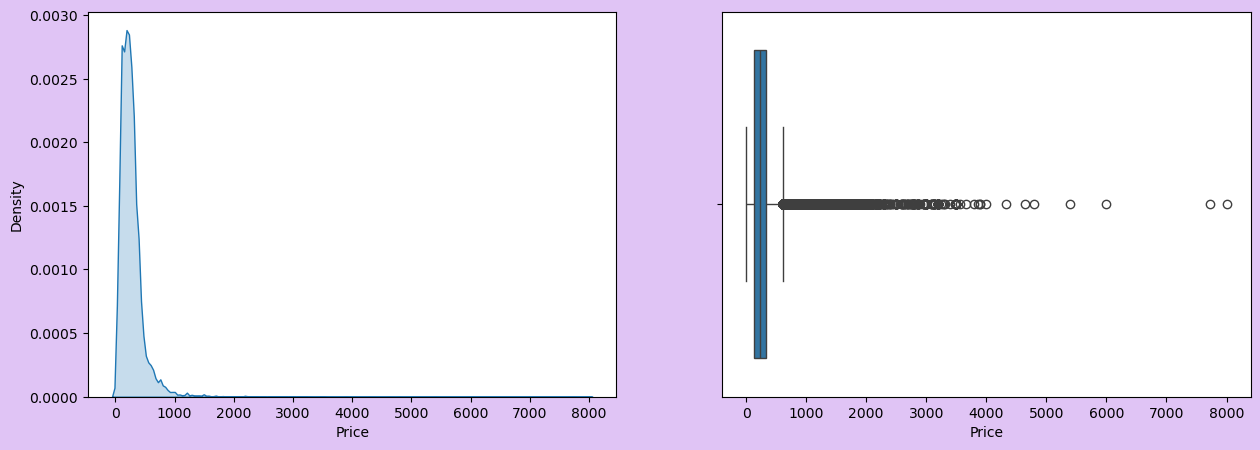

In [8]:
# lets understand about the price column with graphs 
fig , axes = plt.subplots(1,2,figsize=(15,5))
axes = axes.flatten()
fig.patch.set_facecolor("#E0C4F5")

sns.kdeplot(data=data["Price"],fill=True, ax=axes[0])

sns.boxplot(data=data["Price"],fill=True, ax=axes[1],orient="h")
plt.show()

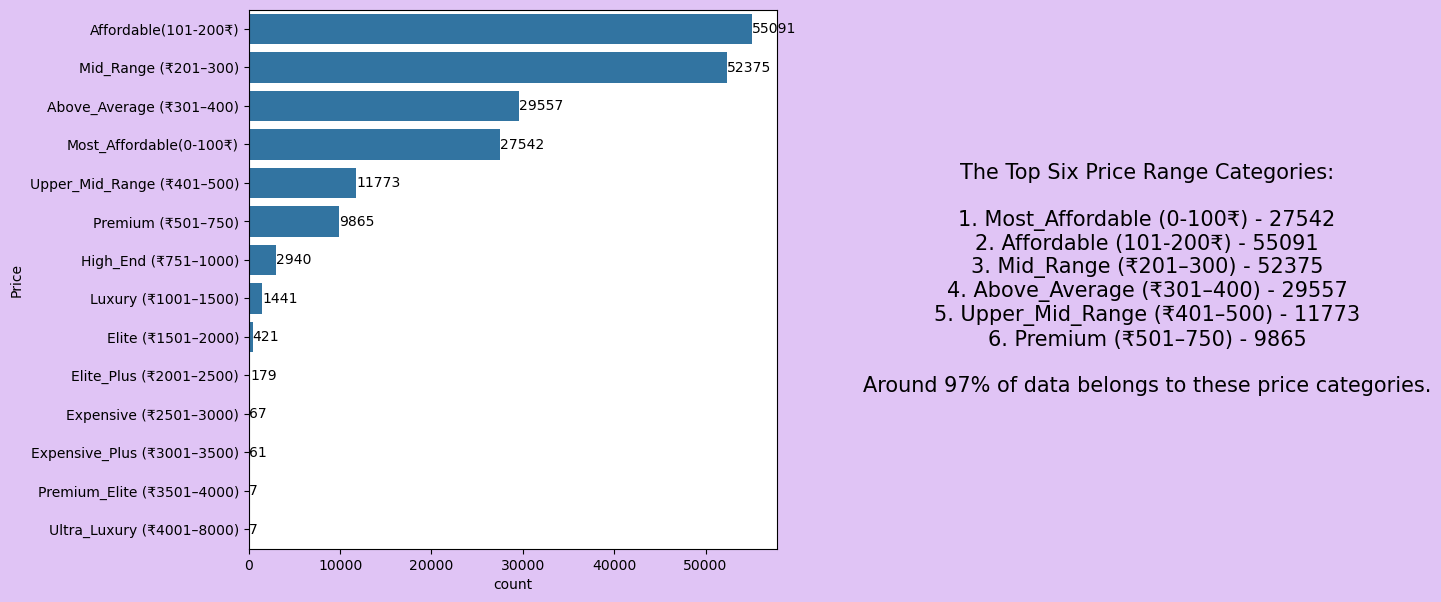

In [9]:
# lets create some bins,labels
bins = [0,100,200,300,400,500,750,1000,1500,2000,2500,3000,3500,4000,8000]
labels = ["Most_Affordable(0-100₹)",
        "Affordable(101-200₹)",
        "Mid_Range (₹201–300)",
        "Above_Average (₹301–400)",
        "Upper_Mid_Range (₹401–500)",
        "Premium (₹501–750)",
        "High_End (₹751–1000)",
        "Luxury (₹1001–1500)",
        "Elite (₹1501–2000)",
        "Elite_Plus (₹2001–2500)",
        "Expensive (₹2501–3000)",
        "Expensive_Plus (₹3001–3500)",
        "Premium_Elite (₹3501–4000)",
        "Ultra_Luxury (₹4001–8000)"]
price_bins = pd.cut(data["Price"],bins = bins , labels = labels)


fig , axes = plt.subplots(1,2,figsize = (15,7))
axes =  axes.flatten()
fig.patch.set_facecolor("#E0C4F5")


bx = sns.countplot(y=price_bins,order =price_bins.value_counts().index,ax= axes[0])
bx.bar_label(bx.containers[0])
plt.xlabel("Number of Items")
plt.ylabel("price range")
plt.xticks(rotation=90)

axes[1].axis("off")
text_str = (
    "The Top Six Price Range Categories:\n\n"
    "1. Most_Affordable (0-100₹) - 27542\n"
    "2. Affordable (101-200₹) - 55091\n"
    "3. Mid_Range (₹201–300) - 52375\n"
    "4. Above_Average (₹301–400) - 29557\n"
    "5. Upper_Mid_Range (₹401–500) - 11773\n"
    "6. Premium (₹501–750) - 9865\n\n"
    "Around 97% of data belongs to these price categories."
    )
axes[1].text(0.5,0.5,text_str,fontsize=15,ha='center',va='center')

plt.show()

### Observations on price column

###### - Around 75% of the food items cost less than ₹329, which means most dishes on Swiggy are quite affordable.
###### - The top 25% of the dishes are priced between ₹329 and ₹8000, shows a wide range of food options.
###### - Only about 7 or 8 dishes cost more than ₹4000, these are very expensive and might depend on the city or special types of food.
###### - Nearly 97% of the food items are priced between ₹0 and ₹750, which shows that Swiggy focuses mostly on providing value-for-money choices for customers and sellers.


In [10]:
# lets classify the numerical and categorical columns 
nums_cols = []
cats_cols = []
for cols in data.columns:
    if data[cols].dtype == "O":
        cats_cols.append(cols)
    else:
        nums_cols.append(cols)

print(f"Total number of Numerical columns are {len(nums_cols)} and they are {nums_cols}")
print("============================================================================================================================")
print(f"Total number of Categorical columns are {len(cats_cols)} and they are {cats_cols}")

Total number of Numerical columns are 3 and they are ['Price', 'Rating', 'Rating Count']
Total number of Categorical columns are 6 and they are ['State', 'City', 'Restaurant Name', 'Location', 'Category', 'Dish Name']


## Univariate analysis on Categorical columns 

In [11]:
# lets understand the unique features in the categorical columns 
for cols in cats_cols:
    print(cols,":",data[cols].nunique(),"Unique features")

State : 28 Unique features
City : 28 Unique features
Restaurant Name : 993 Unique features
Location : 977 Unique features
Category : 4972 Unique features
Dish Name : 59064 Unique features


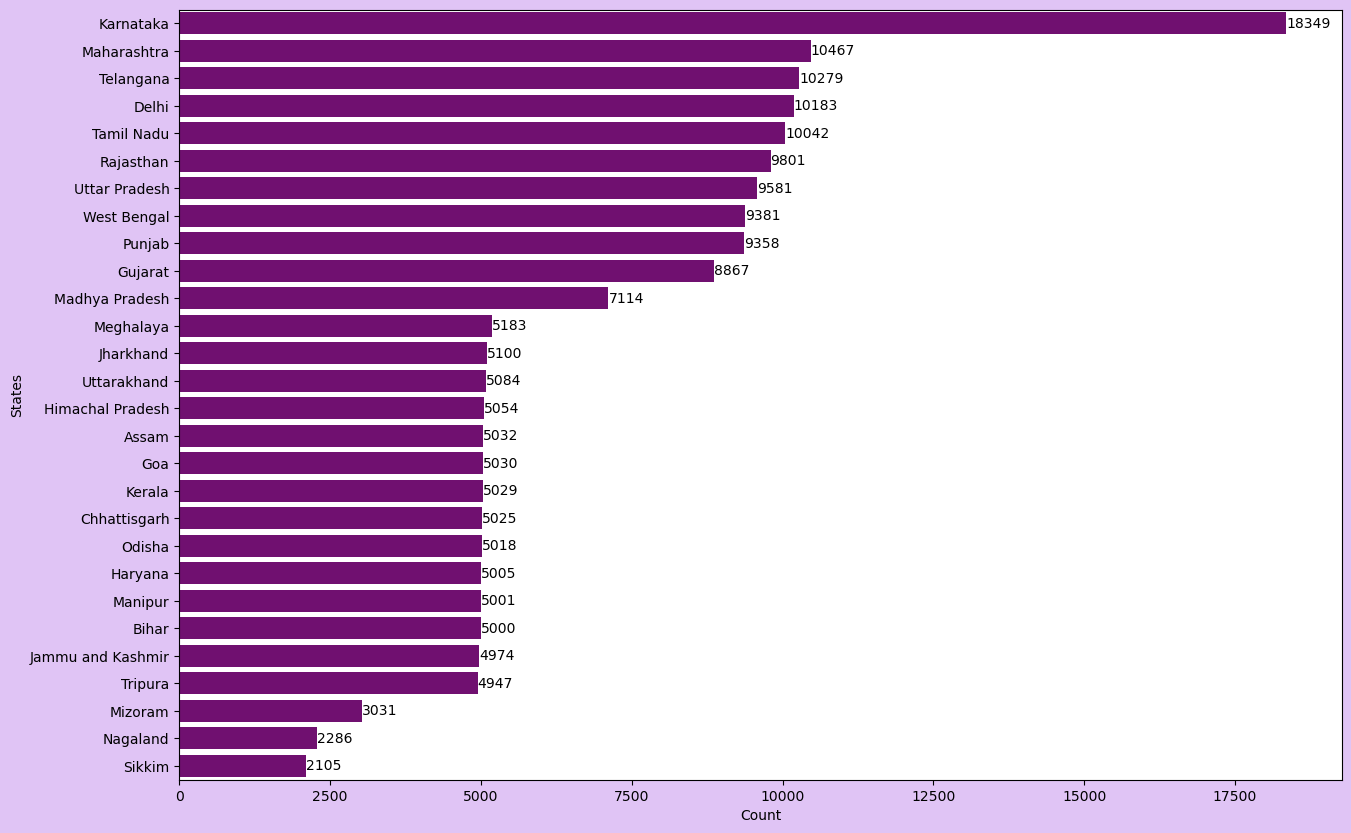

In [12]:
# About state 
plt.figure(figsize=(15, 10),facecolor = "#E0C4F5")

ax=sns.countplot(y=data["State"], order = data["State"].value_counts().index,color="purple")
ax.bar_label(ax.containers[0])
plt.xlabel("Count")
plt.ylabel("States")
plt.show()

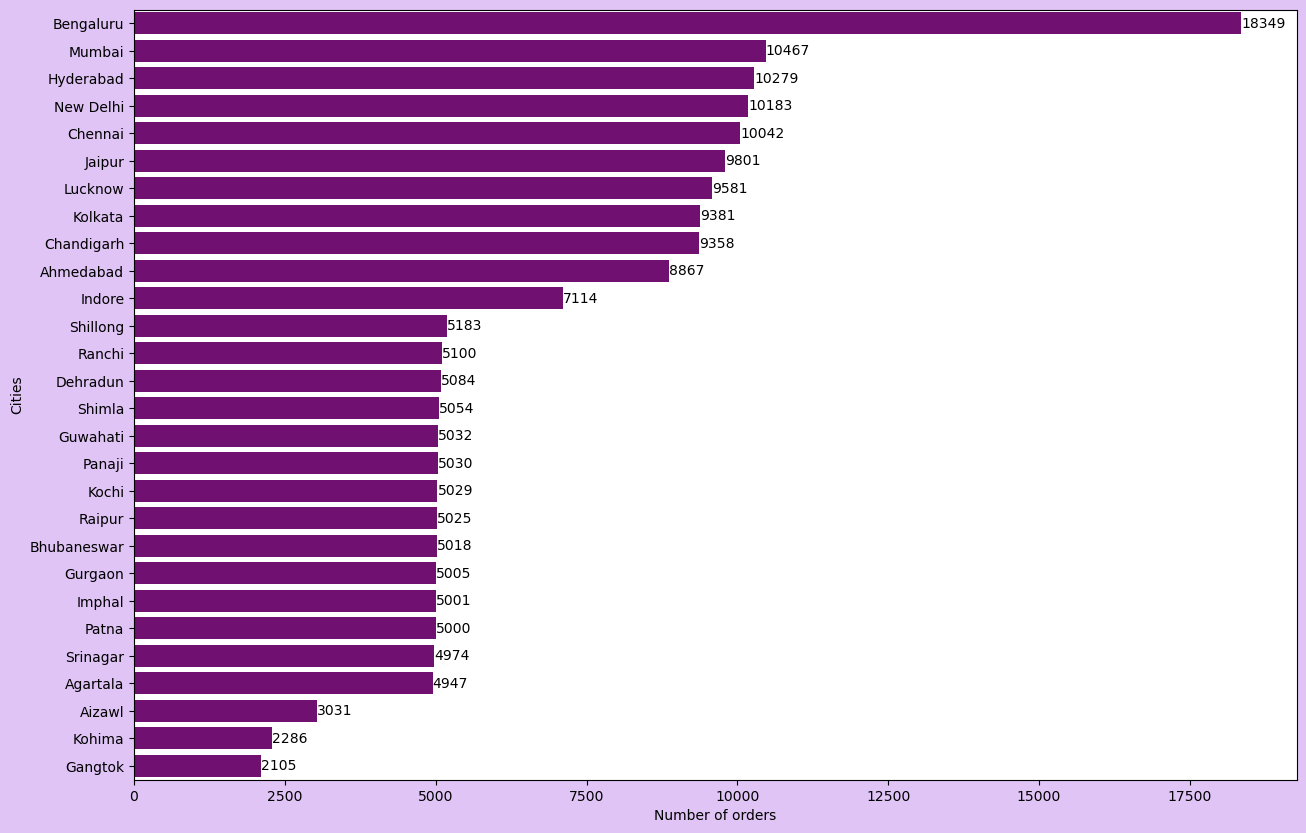

In [13]:
# About city 
plt.figure(figsize=(15,10),facecolor = "#E0C4F5")
ax=sns.countplot(y=data["City"],order = data["City"].value_counts().index,color="purple")
ax.bar_label(ax.containers[0])
plt.xlabel("Number of orders")
plt.ylabel("Cities")
plt.show()

In [14]:
# about restaurants
data["Restaurant Name"].value_counts().head(10)

Restaurant Name
McDonald's                             12833
KFC                                    12203
Burger King                             6576
Pizza Hut                               6353
Domino's Pizza                          5326
LunchBox - Meals and Thalis             4492
Baskin Robbins - Ice Cream Desserts     4032
Faasos - Wraps, Rolls & Shawarma        3112
Olio - The Wood Fired Pizzeria          2973
The Good Bowl                           2575
Name: count, dtype: int64

In [15]:
data["Restaurant Name"].value_counts().tail(20)

Restaurant Name
Krishna Chhole Bhature         5
Biryani Adda                   5
Kolkata Royal Biryani House    4
Krishnashree                   4
M/S Girija Hotel               4
Cocoberry                      4
Biryani Nation                 4
Biryani Hub                    3
Biggies Burger                 3
Pizza Jalapenia (Downtown)     3
Cheapest Food Zone             3
Pizza Jalapenia (Uptown)       3
FNP- Ferns N Petals            3
Hungry Point                   2
Sumi Ethnic                    2
The Complete Comfort Zone      2
Royal Kitchen                  1
Talk Of The Town (Bt Road)     1
Barq Foods                     1
Anand Sweets & Savouries       1
Name: count, dtype: int64

In [16]:
data["Restaurant Name"].describe()

count         191326
unique           993
top       McDonald's
freq           12833
Name: Restaurant Name, dtype: object

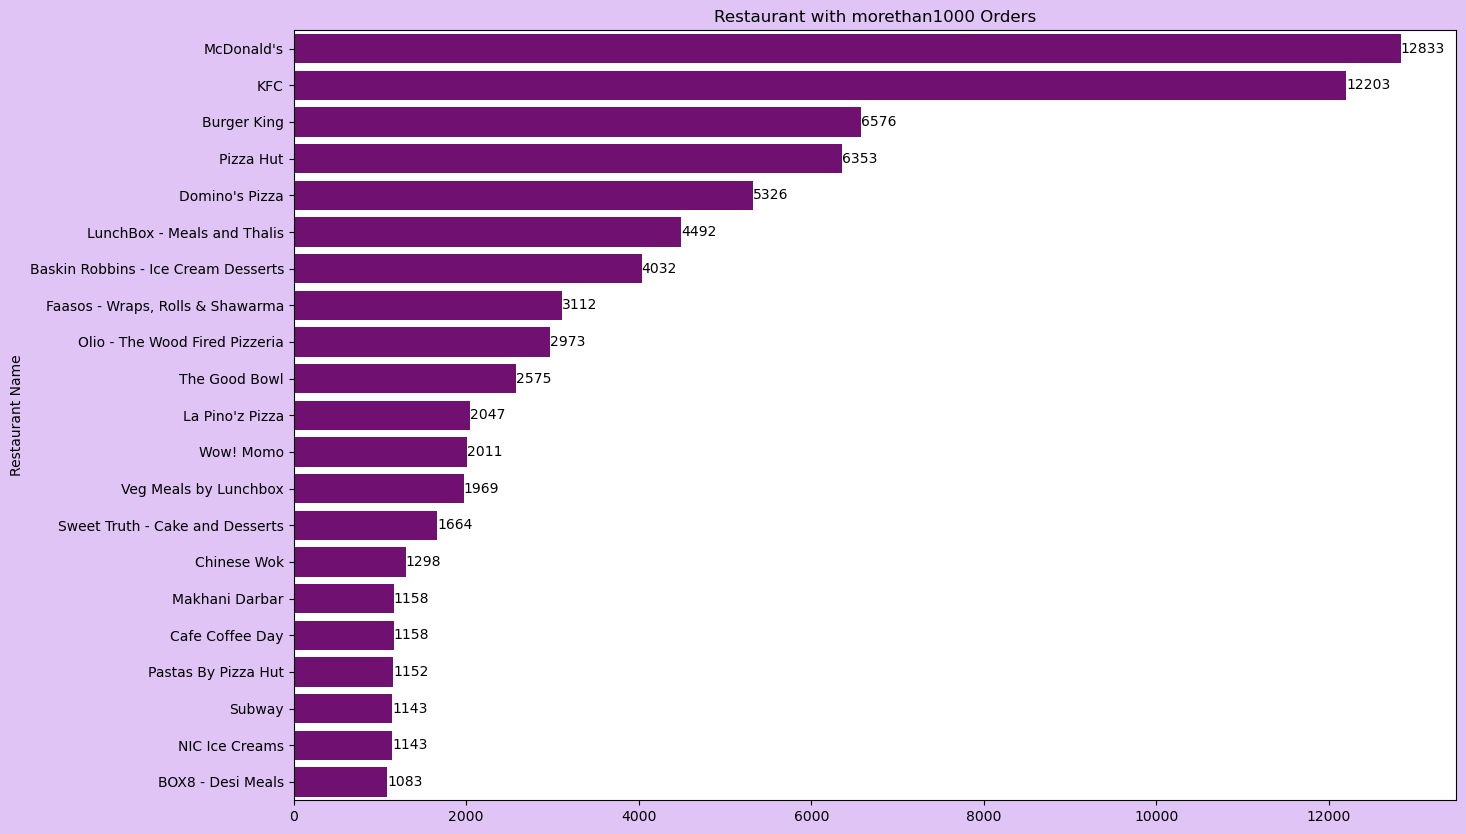

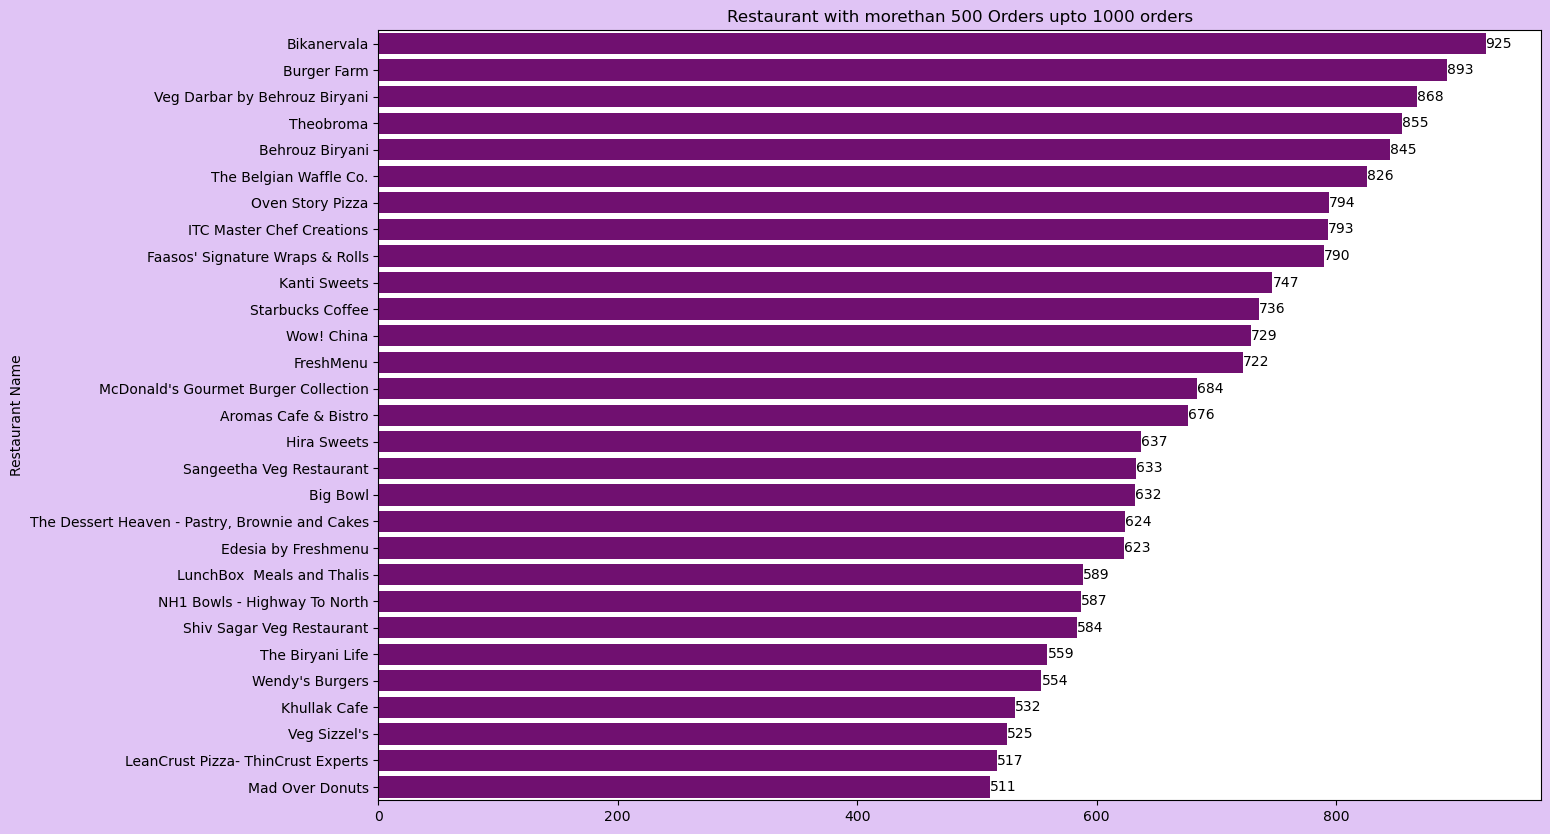

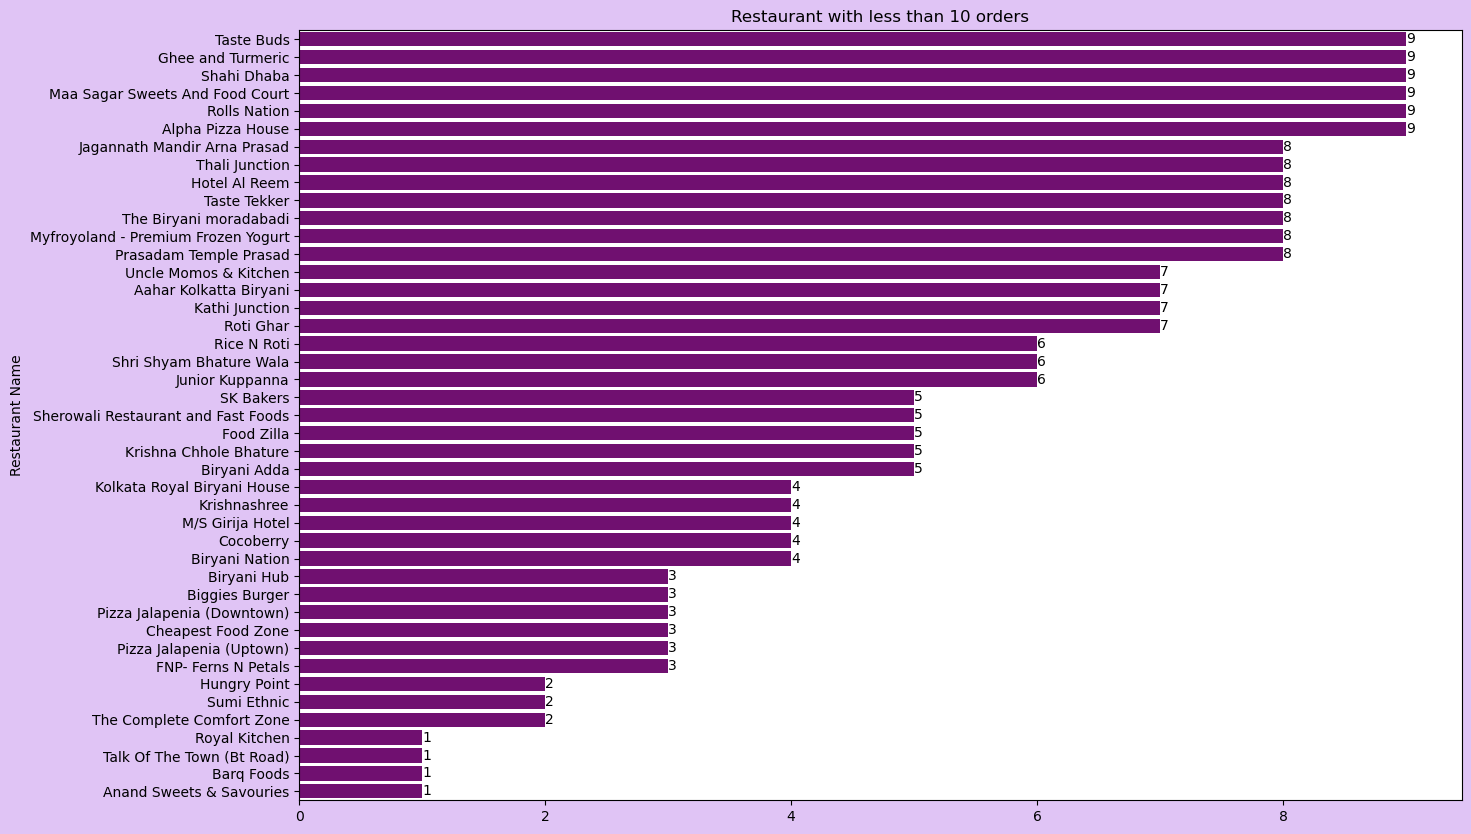

In [17]:
# lets create two graphs 
res_total_order = data["Restaurant Name"].value_counts()
res_with_morethan1000_orders = res_total_order[res_total_order >= 1000]
res_with_morethan500_upto1000_orders = res_total_order[(res_total_order >= 500) & (res_total_order <1000) ]
res_with_lessthan10_orders = res_total_order[res_total_order < 10]

plt.figure(figsize=(15,10),facecolor="#E0C4F5")
plt.title("Restaurant with morethan1000 Orders")
ax=sns.barplot(x=res_with_morethan1000_orders.values,y=res_with_morethan1000_orders.index,color="purple")
ax.bar_label(ax.containers[0])

plt.figure(figsize=(15,10),facecolor="#E0C4F5")
plt.title("Restaurant with morethan 500 Orders upto 1000 orders")
ax=sns.barplot(x=res_with_morethan500_upto1000_orders.values,y=res_with_morethan500_upto1000_orders.index,color="purple")
ax.bar_label(ax.containers[0])

plt.figure(figsize=(15,10),facecolor="#E0C4F5")
plt.title("Restaurant with less than 10 orders")
ax=sns.barplot(x=res_with_lessthan10_orders.values,y=res_with_lessthan10_orders.index,color="purple")
ax.bar_label(ax.containers[0])

plt.show()



In [18]:
# about location  
print(f"The Top 10 : {data["Location"].value_counts().head(10)}")
print("======================================================================")
print(f"The Last 10 : {data["Location"].value_counts().tail(10)}")

The Top 10 : Location
Gomti Nagar      2054
Nerul            2034
Yelahanka        1990
Police Bazar     1814
Vasant Kunj      1789
Whitefield       1727
Thane West       1711
Jagatpura        1662
Gangtok          1544
Shankar Nagar    1460
Name: count, dtype: int64
The Last 10 : Location
Lodha Vesta A-B                    5
Laxminarayan Bari Road             5
Mal Godown Market                  4
UNO Business Center, Patliputra    4
Chanmari                           4
Mirza                              4
ASHIYANA DIGHA ROAD                3
SECTOR-109                         3
Bohri Kadal                        3
Faridabad                          2
Name: count, dtype: int64


In [19]:
# about Category 
data["Category"].value_counts().head(10)

Category
Recommended                        23243
Main Course                         2953
Desserts                            2844
Beverages                           2405
McSaver Combos (2 Pc Meals)         1729
Starters                            1656
Sweets                              1626
Exclusive Deals (Save upto 40%)     1592
Breads                              1378
Snacks                              1350
Name: count, dtype: int64

### - Observation 

##### - The "Recommended" option is not a real food category but shows suggestions based on recent orders or offers or local specialities.  
##### - It includes items from other categories like beverages or snacks (e.g., Badam Milk appears in both Recommended and Beverages).  
##### - Counting "Recommended" as a separate category would be misleading, so we exclude it when finding the top 15 food categories.


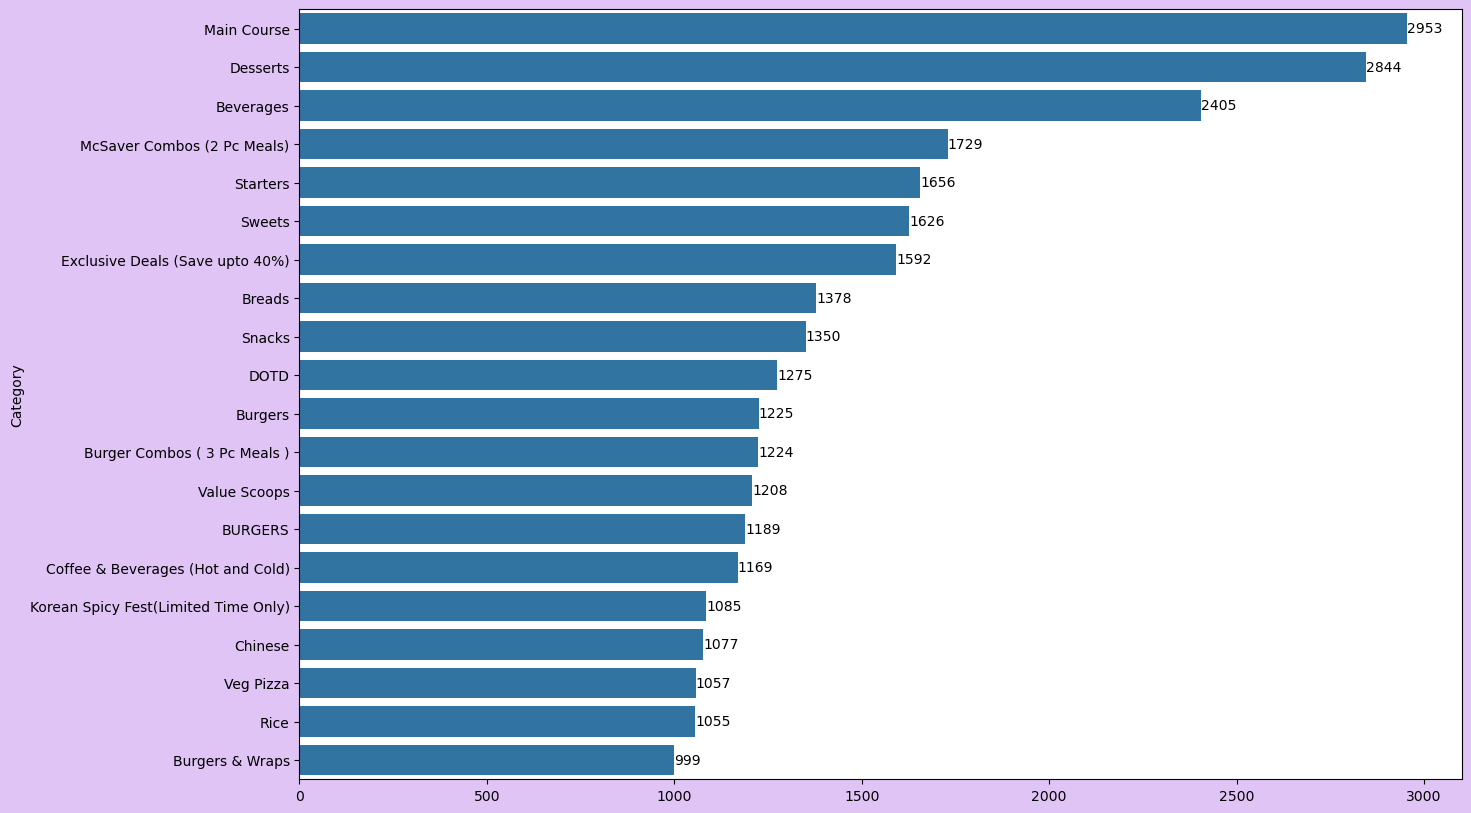

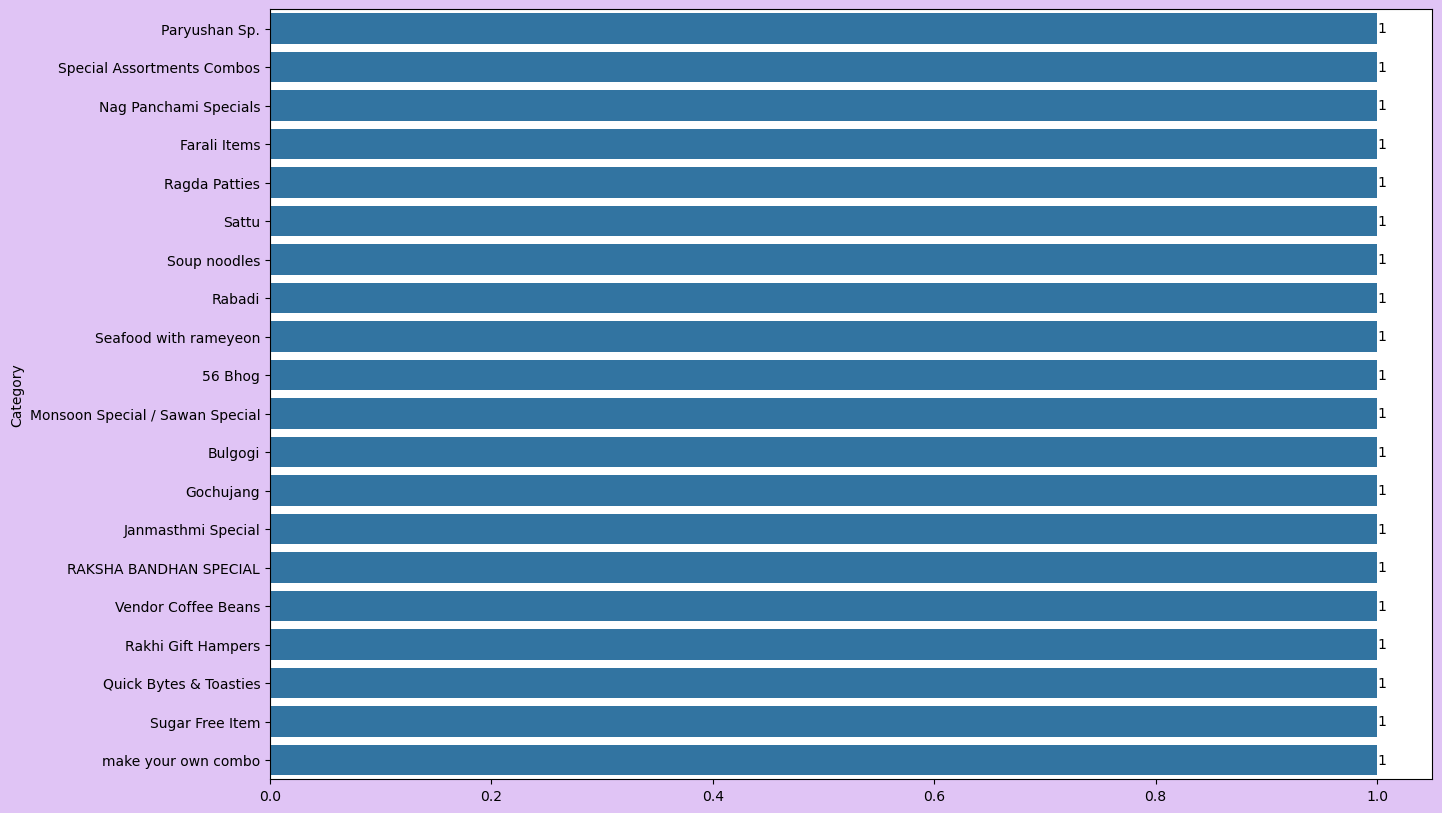

In [20]:
filtered_category = data[data["Category"]!="Recommended"]
category_count_top10 =filtered_category["Category"].value_counts().head(20)
category_count_below10 =filtered_category["Category"].value_counts().tail(20)

plt.figure(figsize=(15,10),facecolor="#E0C4F5")
ax=sns.barplot(x=category_count_top10.values , y=category_count_top10.index)
ax.bar_label(ax.containers[0])

plt.figure(figsize=(15,10),facecolor="#E0C4F5")
ax=sns.barplot(x=category_count_below10.values , y=category_count_below10.index)
ax.bar_label(ax.containers[0])

plt.show()


In [21]:
unique_category = data["Category"].value_counts()
unique_category = unique_category[unique_category==1]
print(f"Total number of Unique categories are {data["Category"].nunique()}.Categories that are ordered only once are : {len(unique_category)}")

Total number of Unique categories are 4972.Categories that are ordered only once are : 336


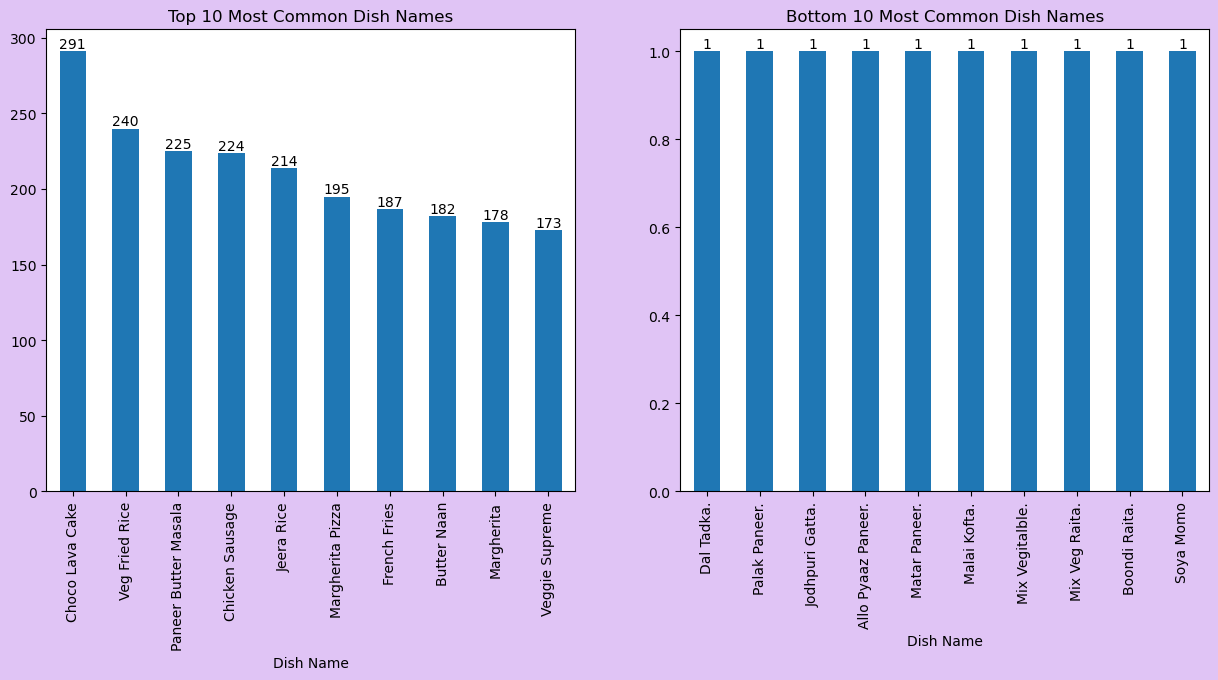

In [22]:
# about Dish Name 
fig , axes = plt.subplots(1,2,figsize=(15,6))
axes=axes.flatten()
fig.patch.set_facecolor("#E0C4F5")
bx = data['Dish Name'].value_counts().head(10).plot(kind='bar', title='Top 10 Most Common Dish Names',ax=axes[0])
bx.bar_label(bx.containers[0])
dx = data['Dish Name'].value_counts().tail(10).plot(kind='bar', title='Bottom 10 Most Common Dish Names',ax=axes[1])
dx.bar_label(dx.containers[0])
plt.show()

In [23]:
dish_counts = data["Dish Name"].value_counts()
dishes_ordered_once = dish_counts[dish_counts == 1]
dishes_ordered_multiple = dish_counts[dish_counts > 1]

print(f"Total Unique number of Dishes : {data["Dish Name"].nunique()}\nDishes that are ordered only once :{len(dishes_ordered_once)}")
print(f"Dishes that are ordered more than once are : {len(dishes_ordered_multiple)}")

Total Unique number of Dishes : 59064
Dishes that are ordered only once :41237
Dishes that are ordered more than once are : 17827


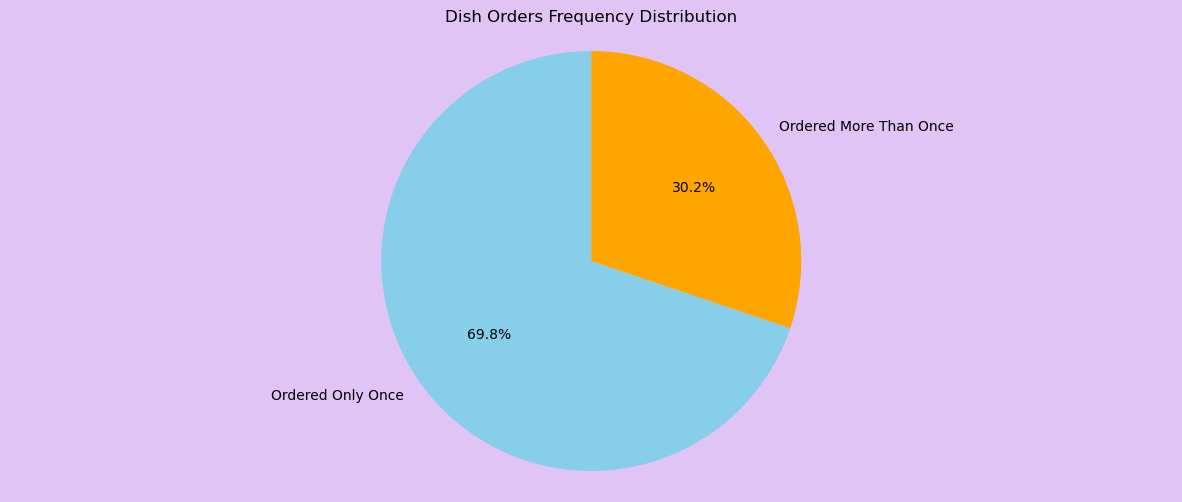

In [24]:
# pie chart representation 

labels = ['Ordered Only Once', 'Ordered More Than Once']
sizes = [41237, 17827]

plt.figure(figsize=(15,6),facecolor=("#E0C4F5"))

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title('Dish Orders Frequency Distribution')
plt.axis('equal')
plt.show()

# Observations On Catergorical columns (Univariate)
***STATES***
- Karnataka leads with 18,000+ orders, likely due to its tech-driven, high-income population.
- 3 out of the Top 5 states are from South India, contributing 31% of total orders — showing stronger adoption of online food delivery in the region.
- States with the top 3 metro cities (Karnataka, Maharashtra, and Telangana) lead in orders, highlighting how urban lifestyle and higher income drive online food delivery.
- NorthEastern states has low orders due to limited population and less urbanization.
- States with Coastlines had significant amount of orders of 35% of total orders.
 
***CITIES***
- The order counts for cities exactly match the counts for their respective states.
- This indicates that the dataset primarily captures data from major metropolitan or capital cities within each state.

***RESTAURANT NAME***
- Top 5 brands (McDonald's, KFC, Burger King, Pizza Hut, Domino's) account for 23% of total orders, driven by brand trust,offers,urban reach.
-  Users prefer popular outlets over new or local ones.People prefer well-known chains over smaller or local restaurants.
-  Restaurants with <10 orders are mostly unrecognized or local, likely lacking visibility or customer trust.

***LOCATION***
- The top 10 locations (Gomti Nagar, Nerul, Yelahanka, Police Bazar, Vasant Kunj, Whitefield, Thane West, Jagatpura, Gangtok, Shankar Nagar)with more than 1500 orders are usually urbanized locations.
- These localities are all urban or rapidly developing suburban hubs with strong infrastructure and high population density.
- As the last 10 locations are having (Lodha Vesta A-B, Laxminarayan Bari Road, Mal Godown Market, UNO Business Center, Patliputra, Chanmari, Mirza, ASHIYANA DIGHA ROAD, SECTOR-109, Bohri Kadal, Faridabad) less than 5 orders.
- From a business perspective, these zones appear to be underpenetrated markets with potential room for growth through targeted expansion or marketing efforts.
  
***CATEGORY***
- The top 3 categories are Main-course, Desserts, and Beverages, which are common and popular food categories that people frequently order.
- Users shows high interest on Baked food items like pizza,burger,rolls etc due to its easy to eat and party culture.
- Combo meals and value deals (e.g., McSaver Combos, Burger Combos, Exclusive Deals) are also highly ordered, indicating price sensitivity and preference for bundled offerings.
- Traditional items like Sweets, Breads, and Rice continue to see good demand, suggesting a balance between modern fast food and regional Indian cuisine preferences.
- There is a long tail of underperforming categories (many with only 1 order), likely due to overly specific or inconsistent naming by vendors.

***Dish Name***
- The Top 10 most ordered dishes are (Choco Lava Cake, Veg Fried Rice, Paneer Butter Masala, Chicken Sausage, Jeera Rice, Margherita Pizza, French Fries, Butter Naan, Margherita, Veggie Supreme) — these are commonly found, affordable, and popular food items.
- There are approximately 41,000 dishes ordered only once, indicating that these are either rare, regional, or specialty dishes. Examples include Dal Tadka, Palak Paneer, Jodhpuri Gatta, Allo Pyaaz Paneer, Matar Paneer, Malai Kofta, Mix Vegetable, Mix Veg Raita, Boondi Raita, among others.
- Among the unique dishes, some are complimentary or side items that are generally not ordered separately, which contributes to the long tail of infrequent orders.


## Univariate analysis on Numerical columns 

In [25]:
# lets understand numerical columns 
print(f"Numerical columns are {nums_cols} and we have already done with Price column, we will analyze the other two columns.")

Numerical columns are ['Price', 'Rating', 'Rating Count'] and we have already done with Price column, we will analyze the other two columns.


In [26]:
# about Rating 
data["Rating"].value_counts().head(15)

Rating
0.0    75490
4.3    11299
4.6    10517
4.4    10431
4.5     9627
5.0     9060
4.7     8781
4.8     8502
4.2     7922
4.1     6909
4.9     5528
4.0     4846
3.9     3883
3.8     3850
3.7     2627
Name: count, dtype: int64

In [27]:
# lets create some bins 
bins = [0, 1.0, 2.0, 3.0, 4.0, 5.0]
labels = ["Unrated(0)","1.1-2","2.1-3","3.1-4","4.1-5"]
rating_bins = pd.cut(data["Rating"],bins = bins , labels= labels,right=True, include_lowest=True )
rating_bins.value_counts(sort =False)

Rating
Unrated(0)    75490
1.1-2           463
2.1-3          3615
3.1-4         23182
4.1-5         88576
Name: count, dtype: int64

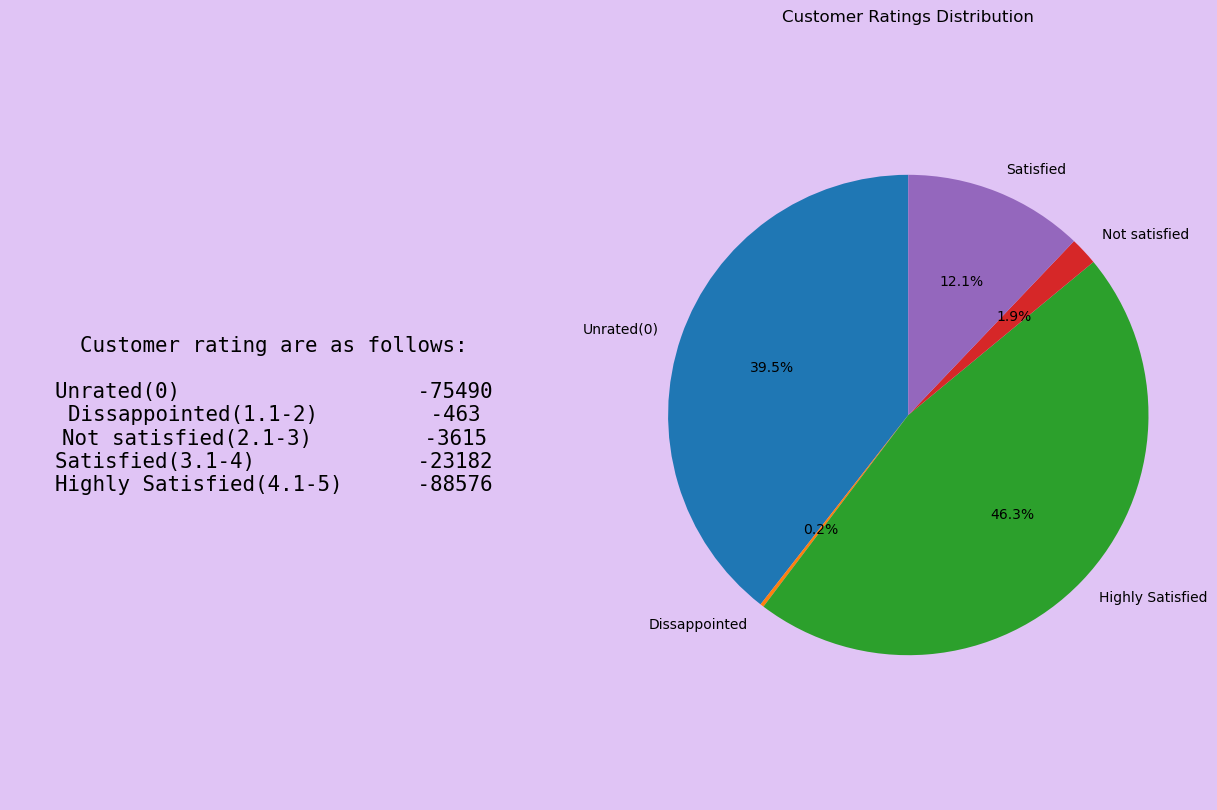

In [28]:
# text 
rating_text =("Customer rating are as follows:\n\n"
              "Unrated(0)                   -75490\n"
              "Dissappointed(1.1-2)         -463\n"
              "Not satisfied(2.1-3)         -3615\n"
              "Satisfied(3.1-4)             -23182\n"
              "Highly Satisfied(4.1-5)      -88576")          


# graph
fig, axes= plt.subplots(1,2,figsize=(15,10))
axes= axes.flatten()
fig.patch.set_facecolor("#E0C4F5")

axes[0].axis("off")
axes[0].text(0.5,0.5,rating_text , ha= "center", va = "center",fontfamily="monospace", fontsize = 15,wrap = True)

label = ["Unrated(0)","Dissappointed","Highly Satisfied","Not satisfied","Satisfied"]
sizes = [75490,463,88576,3615,23182]

axes[1].pie(sizes, labels=label, autopct='%1.1f%%', startangle=90)
axes[1].axis("equal")  
plt.title("Customer Ratings Distribution")

plt.show()


In [29]:
# About Rating Count ( no. of custumers have rated on particular dish)
data["Rating Count"].value_counts().head()

Rating Count
0    76924
1    11479
3     8984
2     8106
4     6773
Name: count, dtype: int64

In [30]:
# Rating count bin 
bins = [-1,0,50,100,200,300,400,500,600,700,800,900,np.inf]
labels = ["unrated","1-50","51-100","101-200","201-300","301-400","401-500","501-600","601-700","701-800","801-900","901+"]
rating_count_bins = pd.cut(data["Rating Count"],bins = bins , labels = labels , include_lowest =True, right  = True)
rating_count_bins.value_counts()


Rating Count
1-50       91547
unrated    76924
51-100      9743
101-200     6429
201-300     2627
301-400     1327
401-500      914
501-600      561
601-700      431
701-800      351
801-900      288
901+         184
Name: count, dtype: int64

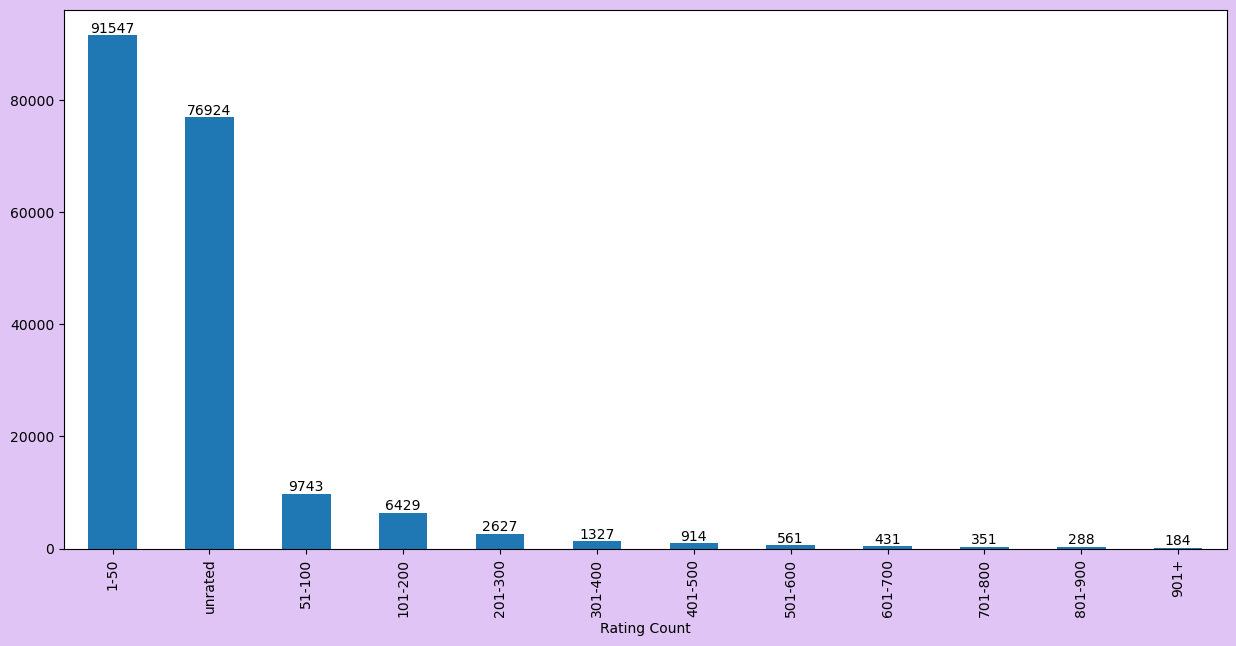

In [31]:
plt.figure(figsize=(15,7),facecolor="#E0C4F5")
ax=rating_count_bins.value_counts().plot(kind="bar")
ax.bar_label(ax.containers[0])
plt.show()

# Observations On Numerical columns (Univariate)
***Prices***
- Around 75% of the food items cost less than ₹329, which means most dishes on Swiggy are quite affordable.
- The top 25% of the dishes are priced between ₹329 and ₹8000, shows a wide range of food options.
- Only about 7 or 8 dishes cost more than ₹4000, these are very expensive and might depend on the city or special types of food.
- Nearly 97% of the food items are priced between ₹0 and ₹750, which shows that Swiggy focuses mostly on providing value-for-money choices for customers and sellers.
  
***RATINGS***
- Most of the dishes (around 46%) are rated above 4, followed by zero ratings (around 39%), which likely represent unrated or missing       ratings.
-  Approximately 12% of dishes received ratings between 3.1 and 4, indicating that these dishes are generally liked by customers but may have room for improvement in taste or presentation.
-  Very few dishes (around 2%) have ratings below 3, highlighting areas that require improvement.
  
***RATING COUNT***
- Only 184 dishes received more than 900 customer ratings, indicating they are frequently sold or highly satisfying.
- About 40% of dishes are unrated, suggesting that customers often skip providing feedback.
- Nearly 48% of dishes have fewer than 50 ratings, meaning they are likely less popular or infrequently ordered.
-Only 12% of dishes (22,855) have more than 100 ratings, showing that a small portion of the menu gets most of the customer attention.


***Ratings and Rating count combined***
- Around 40% of dishes are unrated in both rating score and count, showing limited customer feedback for a large portion of the menu.
- Nearly 47% of dishes have fewer than 50 ratings, suggesting that most dishes are not frequently ordered or reviewed.
- Almost 47% of rated dishes have a high average rating (4.1–5), indicating strong customer satisfaction for those who do leave feedback.
- Very few dishes (less than 2%) have low ratings (below 3), which may suggest customers are more likely to rate when satisfied.
- There's a strong positive skew: high-rated dishes are also likely to have more reviews, showing a correlation between popularity and satisfaction.


## Multi-variate analysis on Categorical and Numerical columns 

In [32]:
print(f"Numerical columns are {nums_cols} \nCategorical columns are {cats_cols}")

Numerical columns are ['Price', 'Rating', 'Rating Count'] 
Categorical columns are ['State', 'City', 'Restaurant Name', 'Location', 'Category', 'Dish Name']


In [33]:
## lets undersand each category with price column

In [34]:
data.describe()

,Price,Rating,Rating Count
count,191326.000000,191326.000000,191326.000000
mean,268.078133,2.607342,28.442601
std,218.580747,2.146412,88.028100
min,0.950000,0.000000,0.000000
25%,139.000000,0.000000,0.000000
50%,229.000000,3.900000,2.000000
75%,329.000000,4.500000,15.000000
max,8000.000000,5.000000,999.000000


### States and regions with prices

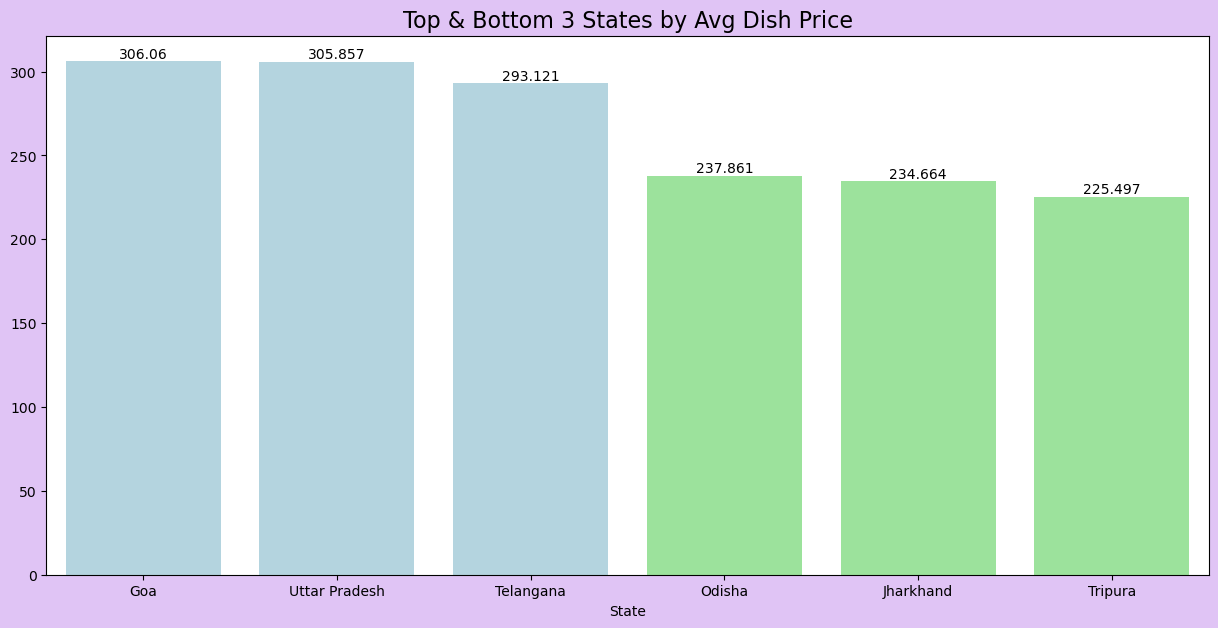

In [35]:
# Top three and bottom three states with avg prices for the dishes.
Avg_price_of_top3_states=data.groupby("State")["Price"].mean().sort_values(ascending=False).head(3)
Avg_price_of_bottom3_states=data.groupby("State")["Price"].mean().sort_values(ascending=False).tail(3)
Avg_price_of_States= pd.concat([Avg_price_of_top3_states,Avg_price_of_bottom3_states],axis = 0)

plt.figure(figsize=(15,7),facecolor ="#E0C4F5")
colors = ['lightblue'] * 3 + ['lightgreen'] * 3
ax=sns.barplot(x=Avg_price_of_States.index, y = Avg_price_of_States.values,palette=colors)
for container in ax.containers:
    ax.bar_label(container)
plt.title("Top & Bottom 3 States by Avg Dish Price", fontsize=16)
plt.show()

In [36]:
# lets create regions for the states
regions = {
    "North": [
        "Jammu and Kashmir", "Himachal Pradesh", "Punjab",
        "Haryana", "Uttarakhand", "Delhi", "Uttar Pradesh", "Chandigarh"
    ],
    "South": [
        "Andhra Pradesh", "Telangana", "Tamil Nadu",
        "Karnataka", "Kerala", "Puducherry"
    ],
    "East": [
        "Bihar", "Jharkhand", "Odisha", "West Bengal"
    ],
    "West": [
        "Rajasthan", "Gujarat", "Maharashtra", "Goa",
        "Dadra and Nagar Haveli and Daman and Diu"
    ],
    "Northeast": [
        "Assam", "Manipur", "Meghalaya", "Mizoram",
        "Nagaland", "Tripura", "Sikkim", "Arunachal Pradesh"
    ]
}

state_to_region = {}
for region,states in regions.items():
    for state in states:
        state_to_region[state]=region


data["Regions"] = data["State"].map(state_to_region)

In [37]:
# lets check the avg price of the dishes by region wise 
data.groupby("Regions")["Price"].mean()


Regions
East         249.457834
North        279.889177
Northeast    253.662274
South        272.824896
West         273.576228
Name: Price, dtype: float64

In [38]:
# lets start with State
avg_price = data.groupby("State")["Price"].mean().sort_values(ascending=False)
no_of_orders = data["State"].value_counts()
states_stats = pd.DataFrame({"Average_price":avg_price,
                             "Number_of_orders":no_of_orders}).sort_index()
states_stats


,Average_price,Number_of_orders
State,,
Assam,250.201161,5032
Bihar,246.339374,5000
Chhattisgarh,244.145711,5025
Delhi,277.699362,10183
Goa,306.059525,5030
Gujarat,275.614463,8867
Haryana,287.403704,5005
Himachal Pradesh,273.583138,5054
Jammu and Kashmir,262.886172,4974


### Restaurant Name with prices

In [39]:
#  Avg Prices,Max prices and number of orders.

Res_stats_1 = data.groupby(["Restaurant Name", "State", "Regions"]).agg(
    Average_Price=('Price', 'mean'),
    Max_Price =  ("Price", "max"),
    Number_of_Orders=('Price', 'count')
).sort_values(by='Max_Price', ascending=False)            # change sort by with "Average_Price","Number_of_Orders" for better views.

Res_stats_1.head()  

,,,Average_Price,Max_Price,Number_of_Orders
Restaurant Name,State,Regions,,,
Madhurima Veg,Uttar Pradesh,North,372.291416,8000.0,332
Bikanervala,Telangana,South,267.358808,4799.0,772
Tossin Pizza,Haryana,North,495.620253,4652.0,158
Ss Hyderabad Biryani,Tamil Nadu,South,255.096953,3900.0,361
Dindigul Thalappakatti - Since 1957,Tamil Nadu,South,331.049251,3899.0,187


In [40]:
#  about category with prices
cat_stats_2 = data.groupby(["Category","State"]).agg(
    Average_Price=('Price', 'mean'),
    Number_of_Orders=('Price', 'count'),
    Max_Price =  ("Price", "max")
).sort_values(by="Max_Price",ascending=False)             # change sort by with "Average_Price","Number_of_Orders" for better views.

cat_stats_2.head()

,,Average_Price,Number_of_Orders,Max_Price
Category,State,,,
PARTY SPECIALS,Uttar Pradesh,5520.833333,6,8000.0
Party Menu for 10pax,Telangana,4299.000000,2,4799.0
Combos,Haryana,1962.125000,8,4652.0
Hyderabadi Dum Biryani (pakki Style),Tamil Nadu,981.857143,14,3900.0
Biryani Buckets (super Savers),Tamil Nadu,2083.444444,9,3899.0


In [41]:
# Dish name with locations 
data.groupby("Regions")["Dish Name"].count()

Regions
East         24499
North        49239
Northeast    27585
South        43699
West         34165
Name: Dish Name, dtype: int64

In [42]:
# lets create some bins for the price range 
bins = [0,100,200,300,400,500,750,1000,1500,2000,2500,3000,3500,4000,8000]
labels = ["Most_Affordable(0-100₹)",
        "Affordable(101-200₹)",
        "Mid_Range (₹201–300)",
        "Above_Average (₹301–400)",
        "Upper_Mid_Range (₹401–500)",
        "Premium (₹501–750)",
        "High_End (₹751–1000)",
        "Luxury (₹1001–1500)",
        "Elite (₹1501–2000)",
        "Elite_Plus (₹2001–2500)",
        "Expensive (₹2501–3000)",
        "Expensive_Plus (₹3001–3500)",
        "Premium_Elite (₹3501–4000)",
        "Ultra_Luxury (₹4001–8000)"]


unique_dishes = data.drop_duplicates(subset=["Dish Name"])       # drop duplicates 
unique_dishes["Price_Category"] = pd.cut(unique_dishes["Price"], bins=bins, labels=labels, include_lowest=True)

unique_dish_counts = unique_dishes[["Price_Category"]].value_counts().sort_index().reset_index(name="dish count")
unique_dish_counts


,Price_Category,dish count
0,Most_Affordable(0-100₹),9373
1,Affordable(101-200₹),17084
2,Mid_Range (₹201–300),14920
3,Above_Average (₹301–400),8211
4,Upper_Mid_Range (₹401–500),4070
5,Premium (₹501–750),3539
6,High_End (₹751–1000),958
7,Luxury (₹1001–1500),543
8,Elite (₹1501–2000),217
9,Elite_Plus (₹2001–2500),75


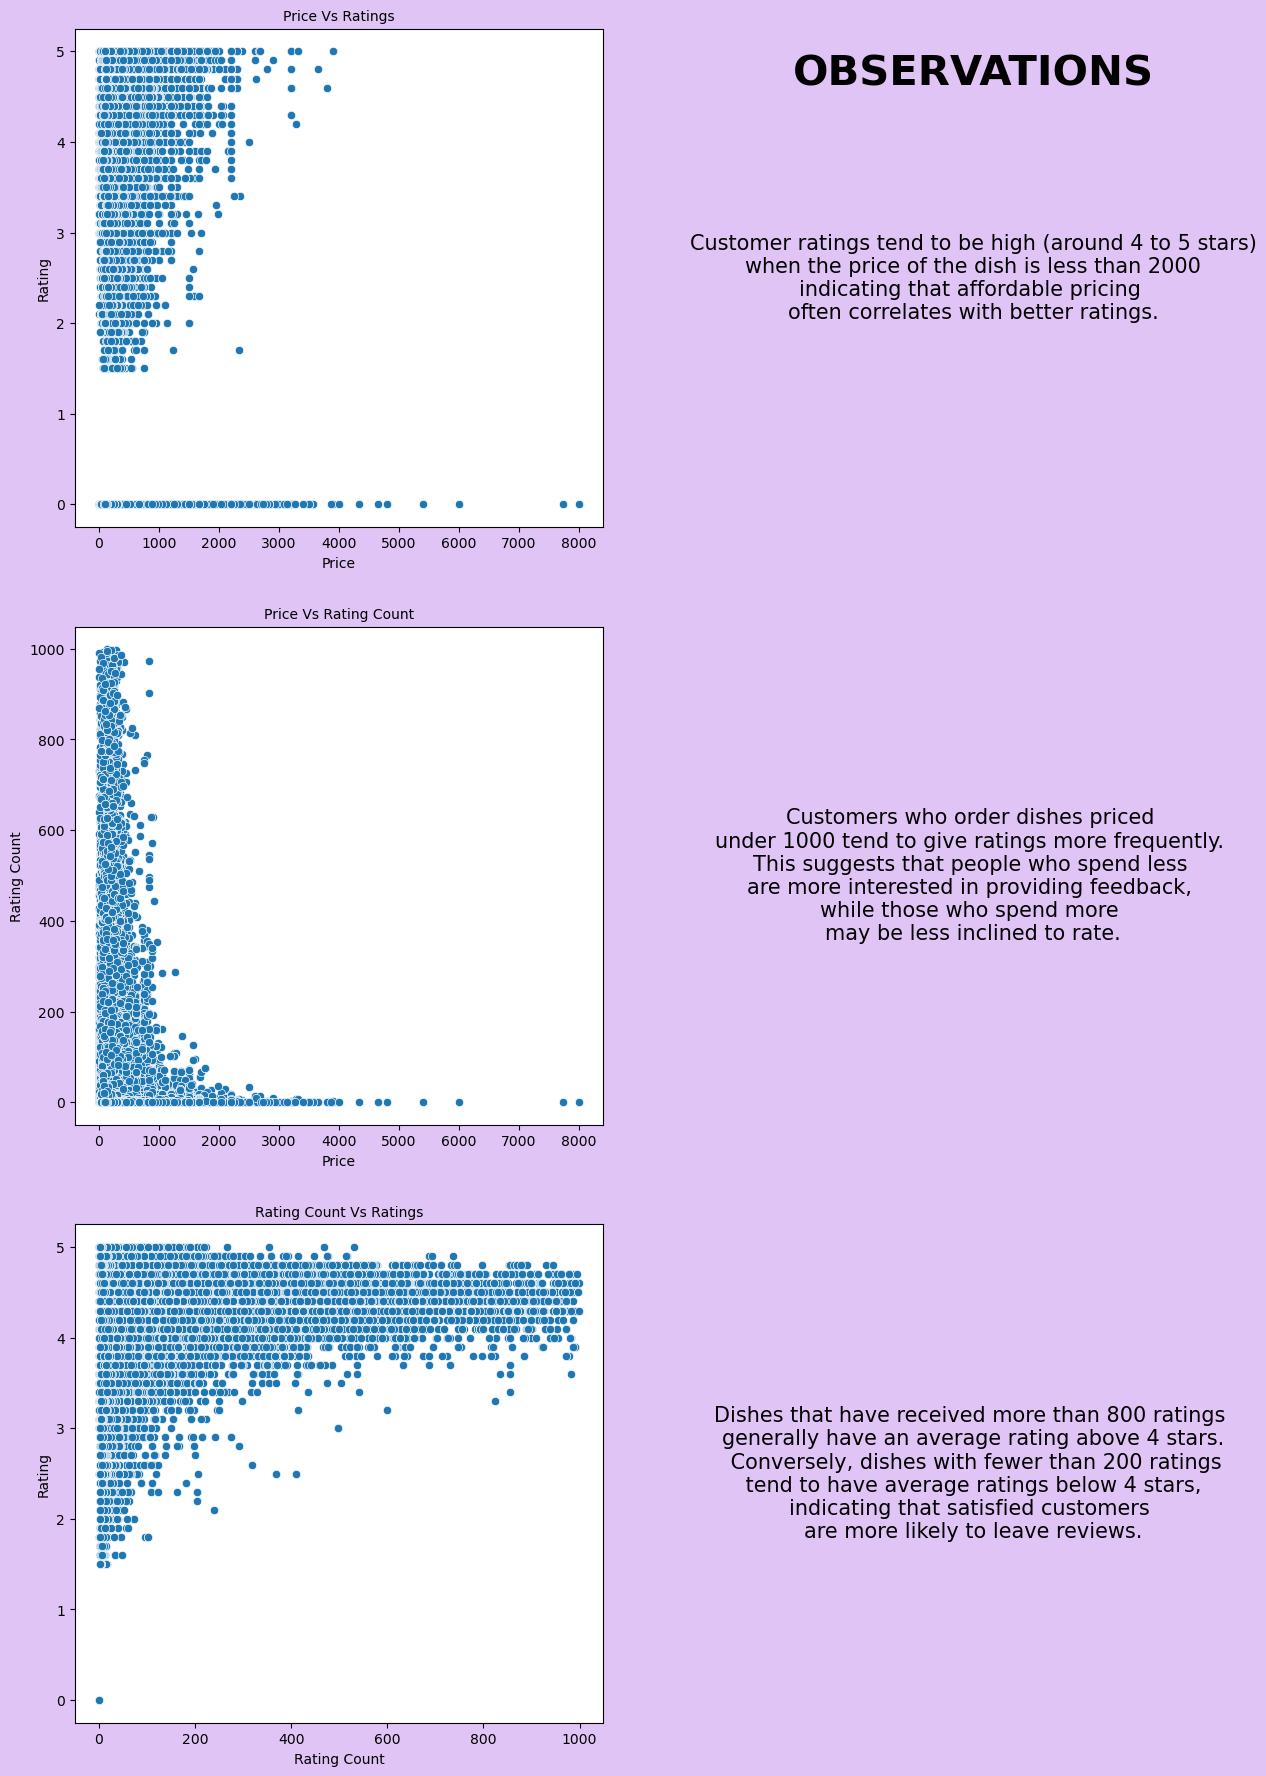

In [43]:
# let me draw the graphs for numercial data
fig, axes = plt.subplots(3,2,figsize=(15,22))
axes=axes.flatten()
fig.patch.set_facecolor("#E0C4F5")

sns.scatterplot(data=data , x="Price" , y ="Rating",ax=axes[0])
axes[0].set_title("Price Vs Ratings",fontsize=10)

axes[1].axis("off")
axes[1].text(0.5, 0.95, "OBSERVATIONS", fontsize=30, ha="center", va="top", weight="bold")
text_1 = ("Customer ratings tend to be high (around 4 to 5 stars)\nwhen the price of the dish is less than 2000\n"
          "indicating that affordable pricing \noften correlates with better ratings.")
axes[1].text(0.5,0.5,text_1,ha="center" , va ="center",fontsize=15)

sns.scatterplot(data=data , x="Price" , y ="Rating Count",ax=axes[2])
axes[2].set_title("Price Vs Rating Count",fontsize=10)

axes[3].axis("off")
text_3 = ("Customers who order dishes priced \nunder 1000 tend to give ratings more frequently. \n"
          "This suggests that people who spend less \nare more interested in providing feedback, \n"
          "while those who spend more \nmay be less inclined to rate.")
axes[3].text(0.5,0.5,text_3,ha="center" , va ="center",fontsize=15)

sns.scatterplot(data=data , x="Rating Count" , y ="Rating",ax=axes[4])
axes[4].set_title("Rating Count Vs Ratings",fontsize=10)

axes[5].axis("off")
text_5 = ("Dishes that have received more than 800 ratings \ngenerally have an average rating above 4 stars.\n "
          "Conversely, dishes with fewer than 200 ratings\n tend to have average ratings below 4 stars, \n"
          "indicating that satisfied customers \nare more likely to leave reviews.")
axes[5].text(0.5,0.5,text_5,ha="center" , va ="center",fontsize=15)

plt.show()



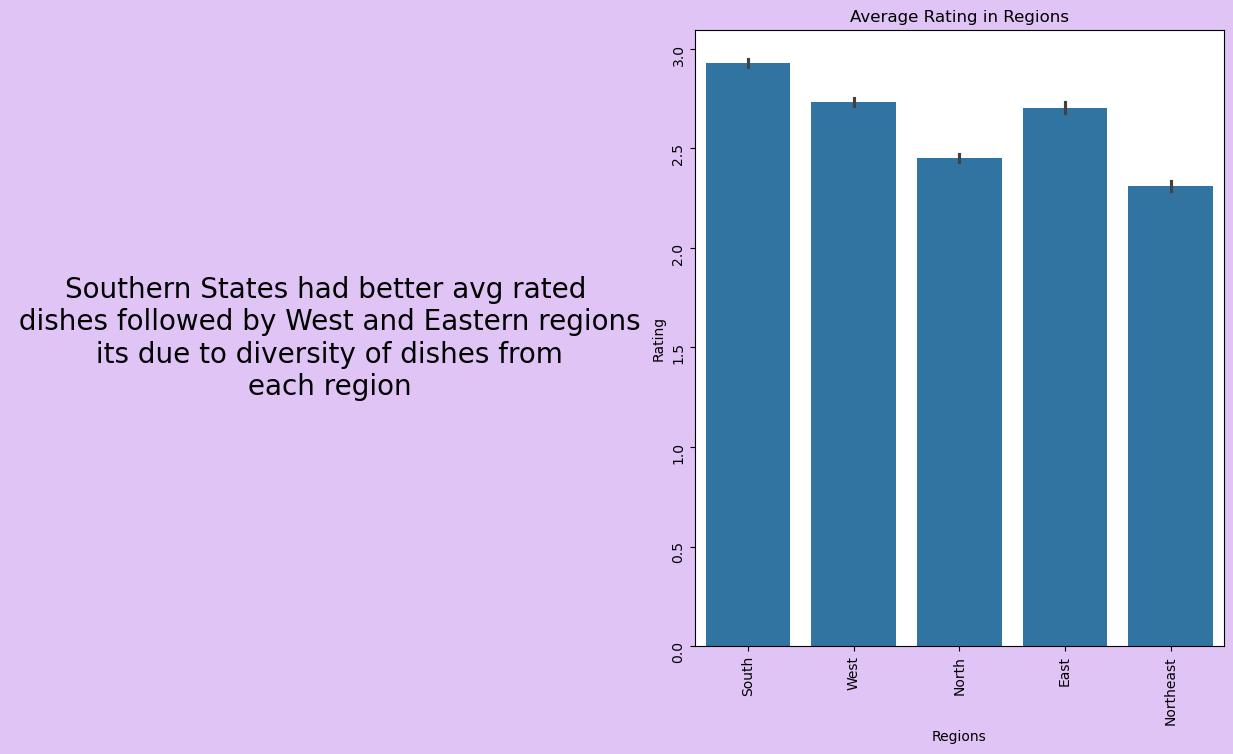

In [44]:
# categroical columns with numerical columns 
fig, axes = plt.subplots(1,2,figsize=(15,8))
axes=axes.flatten()
fig.patch.set_facecolor("#E0C4F5")
axes[0].axis("Off")
axes[0].text(0.5,0.5,"Southern States had better avg rated\n dishes followed by West and Eastern regions\n its due to diversity of dishes from\n each region",ha="center",va="center",fontsize = 20)

top_regions = data['Regions'].value_counts().nlargest(10).index
sns.barplot(data=data[data['Regions'].isin(top_regions)], x='Regions', y='Rating',ax = axes[1])
axes[1].set_title('Average Rating in Regions')
axes[1].tick_params(rotation = 90)

plt.show()

# Observations from Multi-Variate analysis

***States, Regions with Prices***

- Goa has the highest average dish price, driven by its tourism and premium dining culture, followed by UP and Telangana due to urban growth.  
- South Indian states dominate in total order volume, but North Region show slightly higher average prices, which might have influenced the lower number of orders from that Northern states.
- Some Northeastern and smaller states show low orders and lower prices, reflecting limited adoption and market penetration opportunities.

***Restaurants with prices and Number of orders***
  
- Top restaurants with highest average prices are mostly from tech-driven Southern states like Telangana and Tamil Nadu.
- Fast food brands like McDonald's, KFC, Baskin Robbins, and Burger King dominate in order count with avg prices between ₹250–₹350.
- Non-branded restaurants with high avg prices (₹300+) receive fewer orders, showing customer preference for affordability and brand value.
- Madhurima Veg (Uttar Pradesh) is the only restaurant with a dish priced at ₹8000, receiving around 332 orders.
- Bikanervala and Tossin Pizza follow with high-priced dishes (~₹4600–₹4800), recording 772 and 158 orders respectively.
- These cases highlight that a few premium-priced items still attract a notable number of buyers.


***Categories with prices and Number of orders***

- Dishes priced below the average price of ₹268(Overall Avg price of the given data) — including main course, desserts, beverages, starters, and sweets — tend to receive higher order volumes, indicating strong demand for affordable options.
- Combos and deals are highly popular due to their value-for-money appeal, with pricing that stays within the affordable range, even when compared to higher-end dishes.
- Despite their premium pricing, sweet items like traditional desserts, brownies, and cakes consistently attract customer interest — showing indulgent items remain in demand.
- Categories with the highest avg and max prices — like party specials, celebration boxes, family meals, and biryani buckets — cater to group consumption but have limited orders (typically <20), highlighting their niche appeal.
-  Regional insights:
   - Uttar Pradesh, Tamil Nadu, and Telangana see more premium-priced orders.
   - Karnataka leads in total orders, especially for affordable and branded options — reflecting a tech-savvy, urbanized consumer base with high online food ordering behavior.
- Affordable pricing drives volume, value combos dominate demand, premium sweets punch above their price, and regional trends reflect digital maturity and lifestyle preferences.

***Dishes with Regions and prices***

- The North region has the highest number of dishes, followed by the South region. Many dishes are similar but listed under different names and categories across these regions.  
- Most dishes (17,084) fall within the affordable price range of ₹101-200, followed by 14,920 dishes in the mid-range bracket of ₹201-300.  
- As prices increase, the count of premium-priced dishes declines sharply, indicating lower customer preference for higher-priced options.  
- Despite a variety of high-end dishes available, customer orders heavily favor lower-priced categories, reflecting strong preference towards affordability.


# MY FINAL OBSERVATIONS


## 1. Geography & Orders  
- Karnataka leads in orders, driven by urban and tech-savvy users.  
- South Indian states contribute 31% of orders; metro cities dominate order volume.  
- Coastal states have significant orders; Northeast states have low orders and prices.

## 2. Cities & Locations  
- Data mostly covers major metro cities.  
- Urban areas have high order volumes; rural or less developed areas show very low orders.

## 3. Restaurants & Brands  
- Top chains (McDonald's, KFC, Domino's, etc.) account for 23% of orders.  
- Local or less-known restaurants get very few orders.  
- Expensive dishes from non-branded places have low order counts.

## 4. Food Categories & Popular Dishes  
- Main-course, desserts, and beverages are most ordered.  
- Combos and fast foods like pizza and burgers are popular due to price and convenience.  
- Traditional Indian dishes also have steady demand.  
- Many unique dishes are rarely ordered.

## 5. Price Trends  
- 75% of dishes cost under ₹329; 97% under ₹750, showing focus on affordability.  
- Very few dishes cost over ₹4000, mostly specialty items.

## 6. Ratings & Reviews  
- About half the dishes have good ratings (>4), but 40% have no ratings.  
- Affordable dishes get more ratings, premium ones fewer.

## 7. Other Insights  
- Goa has the highest average prices due to tourism.  
- Northern states have higher average prices but fewer orders.  
- Combos boost order volume, showing customers prefer value deals.

---

**Summary:**  
Swiggy orders mainly come from urban, tech-savvy regions. Customers prefer affordable, branded, and convenient options. 
Premium and specialty dishes exist but make up a small part of the market. 
Ratings mostly come from popular, affordable dishes.


# Building a ML model( Random Forest Regression)

In [45]:
# Dropping the Region column (As we added for EDA not necessary for ML )
data.drop(columns= {"Regions"} , inplace = True)

### Data dependency split 

In [46]:
x = data.drop(columns = {"Price"})
y = data[["Price"]]
x.head()

,State,City,Restaurant Name,Location,Category,Dish Name,Rating,Rating Count
0,Karnataka,Bengaluru,Anand Sweets & Savouries,Rajarajeshwari Nagar,Snack,Butter Murukku-200gm,0.0,0
1,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Badam Milk,4.5,25
2,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Chow Chow Bath,4.7,48
3,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Kesari Bath,4.6,65
4,Karnataka,Bengaluru,Srinidhi Sagar Deluxe,Kengeri,Recommended,Mix Raitha,0.0,0


### Train - Test split 

In [47]:
x_train , x_test , y_train , y_test = train_test_split(x,y, test_size = 0.2 , random_state = 42)
# checking the dimensions 
print(f"Training data - Independent features: {x_train.shape}, Dependent target: {y_train.shape}")
print(f"Testing data  - Independent features: {x_test.shape}, Dependent target: {y_test.shape}")

Training data - Independent features: (153060, 8), Dependent target: (153060, 1)
Testing data  - Independent features: (38266, 8), Dependent target: (38266, 1)


### Categorical columns 

In [48]:
cat_cols = []
for cols in data.columns:
    if data[cols].dtype == "O":
        cat_cols.append(cols)

print(f"Categorical columns are { cat_cols } , which are supposed to convert to Numericals")

Categorical columns are ['State', 'City', 'Restaurant Name', 'Location', 'Category', 'Dish Name'] , which are supposed to convert to Numericals


### Unique Features

In [49]:
for cols in data.columns:
    print(cols,":",data[cols].nunique())

State : 28
City : 28
Restaurant Name : 993
Location : 977
Category : 4972
Dish Name : 59064
Price : 2755
Rating : 37
Rating Count : 963


### ENCODING DATA 
#### - we are using two different encoders because of the cardinal features 

In [50]:
low_cardinal = ['State', 'City']                                               # Onehotencoder
high_cardinal = ['Restaurant Name', 'Location', 'Category', 'Dish Name']       # OrdinalEncoding - to ignore any unknown data in test

low_encoder = OneHotEncoder(sparse_output=False , drop ="first" , dtype="i")
high_encoder =OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [51]:
# Encoding training data

# Onehotencoding
x_train_low_encoder = low_encoder.fit_transform(x_train[low_cardinal])
x_train_low_encoder_df = pd.DataFrame(x_train_low_encoder, index = x_train.index , columns=low_encoder.get_feature_names_out())

# labelencoding  - when it is high cardinal data you should run a loop seperately for each column to encode in label encoding
x_train_high_encoder = high_encoder.fit_transform(x_train[high_cardinal])
x_train_high_encoder_df  = pd.DataFrame(x_train_high_encoder, index = x_train.index , columns=high_encoder.get_feature_names_out())


# numerical columns from training data 
x_train_nums_cols = x_train[["Rating","Rating Count"]]

#Final encoded train data 
final_encoded_x_train = pd.concat ([x_train_nums_cols,x_train_low_encoder_df , x_train_high_encoder_df], axis = 1)


In [52]:
# Encoding the test data 

# Onehotencoding 
x_test_low_encoder = low_encoder.transform(x_test[low_cardinal])
x_test_low_encoder_df = pd.DataFrame(x_test_low_encoder , index = x_test.index , columns = low_encoder.get_feature_names_out())

# Labelencoding 
x_test_high_encoder = high_encoder.transform(x_test[high_cardinal])
x_test_high_encoder_df  = pd.DataFrame(x_test_high_encoder, index = x_test.index , columns=high_encoder.get_feature_names_out())

# numerical columns from training data 
x_test_nums_cols = x_test[["Rating","Rating Count"]]

#Final encoded train data 
final_encoded_x_test = pd.concat ([x_test_nums_cols,x_test_low_encoder_df , x_test_high_encoder_df], axis = 1)


### Checking If Encoding was done perfectly or not 

In [53]:
# check the dimensions 
print(f"The final Train encoded data had {final_encoded_x_train.shape} and final test encoded data had {final_encoded_x_test.shape}")

print("==========================================================================")
# check if any missing values and datatypes
missing_value_check = pd.DataFrame({"Missing_values_in_training":final_encoded_x_train.isnull().sum(),
                                    "Datatypes of training":final_encoded_x_train.dtypes,
                                    "Missing_values_in_testing":final_encoded_x_test.isnull().sum(),
                                   "Datatypes of testing":final_encoded_x_test.dtypes,
                                   })

missing_value_check.head()      


## all tests passed and encoding is clean and perfect.

The final Train encoded data had (153060, 60) and final test encoded data had (38266, 60)


,Missing_values_in_training,Datatypes of training,Missing_values_in_testing,Datatypes of testing
Rating,0,float64,0,float64
Rating Count,0,int64,0,int64
State_Bihar,0,int32,0,int32
State_Chhattisgarh,0,int32,0,int32
State_Delhi,0,int32,0,int32


## Model Preparation -RandomForestRegressor

In [54]:
# initialize the model
model = RandomForestRegressor(random_state = 42)

## RandomizedSearchCV - For best params

- Am not running the entire data set into the grid search cv because it takes lot of time for the huge dataset
- so am taking a sample from the entire dataset
- am not using gridsearchcv as it takes too long for results


In [55]:
# we are taking sample size from the data 

sample_size = 10000             
x_train_sampled = final_encoded_x_train.sample(n=sample_size, random_state=42)
y_train_sampled = y_train.loc[x_train_sampled.index]

print(f"Sampled X_train shape: {x_train_sampled.shape}")
print(f"Sampled y_train shape: {y_train_sampled.shape}")


Sampled X_train shape: (10000, 60)
Sampled y_train shape: (10000, 1)


In [56]:
# For best parameters

model = RandomForestRegressor(random_state = 42)
params_required = {"criterion":["squared_error", "absolute_error", "friedman_mse", "poisson"],
                   "max_depth":list(range(10,30)),
                   "min_samples_split":list(range(2,20,2)),
                   "min_samples_leaf":list(range(1,5))}

randomssearch = RandomizedSearchCV(estimator = model,param_distributions=params_required, n_iter=10, n_jobs=-1 , cv = 3 , verbose= 4)
randomssearch.fit(x_train_sampled, y_train_sampled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'friedman_mse',
                                                      'poisson'],
                                        'max_depth': [10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18]},
                   verbose=4)

In [57]:
# from randomizedsearch we got best params

print("Best Parameters:", randomssearch.best_params_)
print("Best CV Score:", randomssearch.best_score_)

best_model = randomssearch.best_estimator_

# Predict on test data
y_pred = best_model.predict(final_encoded_x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse}")
print(f"Test R2 Score: {r2}")


Best Parameters: {'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 24, 'criterion': 'poisson'}
Best CV Score: 0.2760462746944356
Test MSE: 32684.497067080218
Test R2 Score: 0.2987791670477936


In [64]:
## Training the model 
final_model = RandomForestRegressor(random_state = 42,min_samples_split= 6,min_samples_leaf= 2,max_depth=24, criterion='poisson')
training_model = final_model.fit(final_encoded_x_train , y_train)

y_train_pred = training_model.predict(final_encoded_x_train)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Training MSE: {train_mse}")
print(f"Training R2 Score: {train_r2}")

Training MSE: 5133.488498865155
Training R2 Score: 0.8932051337917349


In [65]:
## Testing the model
y_test_pred = training_model.predict(final_encoded_x_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {test_mse}")
print(f"Test R2 Score: {test_r2}")


Test MSE: 14259.618243211366
Test R2 Score: 0.6940708201333692




## Model Interpretation and Insights

The Random Forest Regression model was trained to predict dish prices using a combination of restaurant details, location, category, and ratings. After tuning hyperparameters through cross-validation, the model's performance was evaluated on both training and test datasets.

### Training Performance:
- The **Mean Squared Error (MSE)** (5133) on the training set is approximately ₹72 variance, indicating that on average, the squared difference between the predicted prices and actual prices is relatively low.
- The **R² score** of 0.89 means the model explains 89% of the variation in dish prices in the training data. This suggests the model has learned the relationships well and fits the data strongly without overfitting.

### Test Performance:
- The **Test MSE** is around 14259 that is ₹119 variance, which is higher than the training MSE, as expected. This increase shows some loss in precision when the model encounters new, unseen data.
- The **Test R² score** is 0.69, meaning the model explains 69% of the variance in dish prices on the test data. While lower than training, it still represents a decent level of generalization and predictive capability.

### Overall Insights:
- The model successfully captures the complex patterns in the data, particularly the effects of restaurant, location, category, and ratings on dish prices.
- The performance gap between training and test sets indicates there is room for improvement, but the current model provides a strong baseline.
- This Random Forest model can be used confidently for price prediction tasks and can be further refined with additional feature engineering or more advanced modeling techniques.


